In [1]:
from common import colors, pvalue_thresholds, insetlw, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
from scipy import stats
from ezephys import pltools

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))

In [5]:
IMG_PATH = os.getenv('IMG_PATH')

# Load data

In [6]:
params_heated = pd.read_csv(
    os.path.join(
        os.getenv('DATA_PATH'), 'models', '5HT_heated', 'model_params.csv'
    )
)
params_heated['temperature'] = '29C-30C'
params_room_temp = pd.read_csv(
    os.path.join(os.getenv('DATA_PATH'), 'models', '5HT', 'model_params.csv')
)
params_room_temp['temperature'] = 'RT'
params = pd.concat([params_heated, params_room_temp])
del params_heated, params_room_temp
print(params.shape)

(144, 38)


In [7]:
params.head()

,C,DV,E_K,El,Tref,Vr,Vt_star,cell_type,dt,eta_10.0,...,m_A,m_Vhalf,m_k,n_A,n_Vhalf,n_k,name,resting_potential,type,temperature
0,0.136998,2.290847,-101.0,-42.272509,6.5,-54.729272,-42.303410,5HT,0.1,-0.096361,...,1849.0,92.77,0.06646,1.264,-25.64,0.2337,DRN1018,-43.700972,AugmentedGIF,29C-30C
1,0.100189,3.343279,-101.0,-44.792587,6.5,-52.086828,-49.824712,5HT,0.1,-0.029269,...,1849.0,92.77,0.06646,1.264,-25.64,0.2337,DRN1008,-44.989371,AugmentedGIF,29C-30C
2,0.097925,2.601143,-101.0,-79.498344,6.5,-51.034729,-48.670517,5HT,0.1,-0.003282,...,1849.0,92.77,0.06646,1.264,-25.64,0.2337,DRN1010,-80.355022,AugmentedGIF,29C-30C
3,0.055019,3.534981,-101.0,-68.125304,6.5,-52.537446,-55.306669,5HT,0.1,-0.012637,...,1849.0,92.77,0.06646,1.264,-25.64,0.2337,DRN1011,-68.714142,AugmentedGIF,29C-30C
4,0.075796,6.574213,-101.0,-70.874911,6.5,-49.386072,-56.623989,5HT,0.1,-0.003930,...,1849.0,92.77,0.06646,1.264,-25.64,0.2337,DRN1012,-72.659922,AugmentedGIF,29C-30C


In [8]:
params.columns

Index([u'C', u'DV', u'E_K', u'El', u'Tref', u'Vr', u'Vt_star', u'cell_type',
       u'dt', u'eta_10.0', u'eta_100.0', u'eta_1000.0', u'eta_3.0',
       u'eta_30.0', u'eta_300.0', u'eta_3000.0', u'gamma_3.0', u'gamma_30.0',
       u'gamma_300.0', u'gamma_3000.0', u'gbar_K1', u'gbar_K2', u'gl', u'h_A',
       u'h_Vhalf', u'h_k', u'h_tau', u'lambda0', u'm_A', u'm_Vhalf', u'm_k',
       u'n_A', u'n_Vhalf', u'n_k', u'name', u'resting_potential', u'type',
       u'temperature'],
      dtype='object')

# Compute additional features

- Time constant
- Distance to threshold
- Spike triggered current integral
- Spike triggered threshold movement integral

In [9]:
params['thresh_dist'] = params['Vt_star'] - params['resting_potential']
params['time_const'] = params['C'] / params['gl']

In [10]:
def get_kernel_integral(model_param_df, kernel_name):
    integrals = np.zeros(model_param_df.shape[0], dtype=np.float64)
    
    for colname in model_param_df.columns:
        match = re.search('{}_(.*)'.format(kernel_name), colname)
        if match is not None:
            try:
                timescale = float(match.groups()[0])
                integrals += model_param_df[colname] * timescale
            except ValueError:
                pass
    
    return integrals

def _monoexponential_integral(scale, tau, start, end):
    """Evaluate the integral of scale * e^{-t/tau} from t=start to end."""
    return scale * tau * (np.exp(-start / tau) - np.exp(-end / tau))

def get_kernel_integral_over_range(model_param_df, kernel_name, start, end):
    integrals = np.zeros(model_param_df.shape[0], dtype=np.float64)
    
    for colname in model_param_df.columns:
        match = re.search('{}_(.*)'.format(kernel_name), colname)
        if match is not None:
            try:
                timescale = float(match.groups()[0])
                integrals += _monoexponential_integral(model_param_df[colname], timescale, start, end)
            except ValueError:
                # ValueError if match cannot be converted to float.
                pass
    
    return integrals

In [11]:
y = 2 * np.exp(-np.arange(10, 40, 0.0001) / 30.)
print(y.sum() * 0.0001)
print(_monoexponential_integral(2., 30., 10., 40.))

27.176095640952635
27.17605034748375


In [12]:
params['gamma_integral'] = get_kernel_integral(params, 'gamma')
params['gamma_integral_log10'] = np.log10(params['gamma_integral'])
params['gamma_integral_100_300'] = get_kernel_integral_over_range(params, 'gamma', 100., 300.)
params['eta_integral'] = get_kernel_integral(params, 'eta')
params['eta_integral_100_300'] = get_kernel_integral_over_range(params, 'eta', 100., 300.)

/home/efharkin/.miniconda3/envs/raphegif/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [13]:
params[['gamma_integral', 'temperature']]

,gamma_integral,temperature
0,-4.074205e+02,29C-30C
1,4.555417e+02,29C-30C
2,1.380107e+09,29C-30C
3,1.778307e+03,29C-30C
4,1.055038e+03,29C-30C
5,-6.342108e+02,29C-30C
6,4.800311e+02,29C-30C
7,5.793659e+03,29C-30C
8,1.872719e+02,29C-30C
9,3.474339e+05,29C-30C


# Select models for each cell type and remove unnecessary features

Based on performance, use
- AugmentedGIF for 5HT
- iGIF for GABA
- GIF for mPFC

In [14]:
params_cleaned = params.copy()
params_cleaned.drop(
    columns=[
        'Tref',
        'dt',
        'E_K',
        'gbar_K1',
        'gbar_K2',
        'h_A',
        'h_Vhalf',
        'h_k',
        'lambda0',
        'm_A',
        'm_Vhalf',
        'm_k',
        'n_A',
        'n_Vhalf',
        'n_k',
        'h_tau',
    ],
    inplace=True,
)
params_cleaned = params_cleaned.loc[
    (params_cleaned['cell_type'] == '5HT')
    & (params_cleaned['type'] == 'AugmentedGIF'),
    :,
]
params_cleaned.drop(columns=['name', 'type'], inplace=True)

params_cleaned.head()

,C,DV,El,Vr,Vt_star,cell_type,eta_10.0,eta_100.0,eta_1000.0,eta_3.0,...,gl,resting_potential,temperature,thresh_dist,time_const,gamma_integral,gamma_integral_log10,gamma_integral_100_300,eta_integral,eta_integral_100_300
0,0.136998,2.290847,-42.272509,-54.729272,-42.303410,5HT,-0.096361,0.063468,-0.020258,0.014951,...,0.002952,-43.700972,29C-30C,1.397562,46.404852,-4.074205e+02,NaN,429.970972,27.345882,2.839592
1,0.100189,3.343279,-44.792587,-52.086828,-49.824712,5HT,-0.029269,0.032779,0.001068,0.020782,...,0.003367,-44.989371,29C-30C,-4.835341,29.757912,4.555417e+02,2.658528,388.875026,3.805657,1.845499
2,0.097925,2.601143,-79.498344,-51.034729,-48.670517,5HT,-0.003282,0.019771,0.002292,0.028742,...,0.001403,-80.355022,29C-30C,31.684505,69.819952,1.380107e+09,9.139913,842.236374,7.633818,1.589918
3,0.055019,3.534981,-68.125304,-52.537446,-55.306669,5HT,-0.012637,0.008316,-0.001277,0.001902,...,0.001721,-68.714142,29C-30C,13.407473,31.968638,1.778307e+03,3.250007,675.340281,5.544076,0.796362
4,0.075796,6.574213,-70.874911,-49.386072,-56.623989,5HT,-0.003930,0.026795,-0.000277,0.009668,...,0.001952,-72.659922,29C-30C,16.035933,38.836731,1.055038e+03,3.023268,755.033437,4.093555,0.902933


In [15]:
print(params_cleaned.columns)

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'cell_type', u'eta_10.0',
       u'eta_100.0', u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0',
       u'eta_3000.0', u'gamma_3.0', u'gamma_30.0', u'gamma_300.0',
       u'gamma_3000.0', u'gl', u'resting_potential', u'temperature',
       u'thresh_dist', u'time_const', u'gamma_integral',
       u'gamma_integral_log10', u'gamma_integral_100_300', u'eta_integral',
       u'eta_integral_100_300'],
      dtype='object')


In [16]:
print(params_cleaned.shape)

(36, 27)


In [17]:
jointspec = gs.GridSpec(
    2,
    2,
    height_ratios=[0.2, 1],
    width_ratios=[1, 0.2],
    top=0.95,
    right=0.95,
    bottom=0.2,
    left=0.2,
)


def jointplot(
    x, y, group, data, group_order=None, group_palette=None, figsize=(2, 2)
):
    plt.figure(figsize=figsize)

    scatter_ax = plt.subplot(jointspec[1, 0])
    sns.scatterplot(
        x=x,
        y=y,
        hue=group,
        data=data,
        hue_order=group_order,
        palette=group_palette,
    )
    pltools.hide_border('tr', trim=True)
    #scatter_ax.legend().remove()

    top_marginal_ax = plt.subplot(jointspec[0, 0])
    sns.boxplot(
        x=x,
        y=group,
        data=data,
        orient='h',
        fliersize=2,
        order=group_order,
        palette=group_palette,
    )
    plt.xlim(scatter_ax.get_xlim())
    pltools.hide_border('a')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend().remove()

    right_marginal_ax = plt.subplot(jointspec[1, 1])
    sns.boxplot(
        x=group,
        y=y,
        data=data,
        fliersize=2,
        order=group_order,
        palette=group_palette,
    )
    plt.ylim(scatter_ax.get_ylim())
    pltools.hide_border('a')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend().remove()

    return {
        'scatter_ax': scatter_ax,
        'top_marginal_ax': top_marginal_ax,
        'right_marginal_ax': right_marginal_ax,
    }

Saving svg
Saving png
Done!


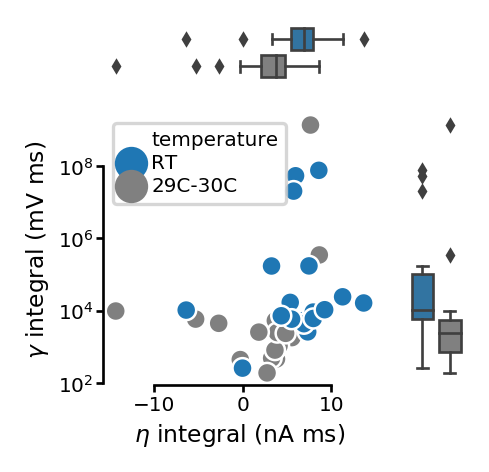

In [18]:
axes = jointplot(
    'eta_integral',
    'gamma_integral_log10',
    'temperature',
    params_cleaned,
    ['RT', '29C-30C'],
    [colors['ser'], 'gray'],
)
axes['scatter_ax'].set_yticklabels(
    ['$10^{{{:.0f}}}$'.format(y) for y in axes['scatter_ax'].get_yticks()]
)
axes['scatter_ax'].set_ylabel('$\gamma$ integral (mV ms)')
axes['scatter_ax'].set_xlabel('$\eta$ integral (nA ms)')

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'joint_adaptation_params'))

Note: some cells with overall negative $\gamma$ integral in the 29C-30C condition are omitted (see below).

In [19]:
params_cleaned['nonpos_gamma_integral'] = params_cleaned['gamma_integral'] <= 0
params_cleaned.loc[:, ['temperature', 'nonpos_gamma_integral']].groupby('temperature').sum()

,nonpos_gamma_integral
temperature,
29C-30C,2.0
RT,0.0


In [20]:
params_cleaned.groupby('temperature').count()

,C,DV,El,Vr,Vt_star,cell_type,eta_10.0,eta_100.0,eta_1000.0,eta_3.0,...,gl,resting_potential,thresh_dist,time_const,gamma_integral,gamma_integral_log10,gamma_integral_100_300,eta_integral,eta_integral_100_300,nonpos_gamma_integral
temperature,,,,,,,,,,,,,,,,,,,,,
29C-30C,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,16,18,18,18,18
RT,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18


In [21]:
stats.mannwhitneyu(
    params_cleaned.query('temperature == "RT"')['gamma_integral'],
    params_cleaned.query('temperature == "29C-30C"')['gamma_integral'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=263.0, pvalue=0.001474381320485359)

In [22]:
stats.mannwhitneyu(
    params_cleaned.query('temperature == "RT"')['eta_integral'],
    params_cleaned.query('temperature == "29C-30C"')['eta_integral'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=240.0, pvalue=0.014206802217273171)

Saving svg
Saving png
Done!


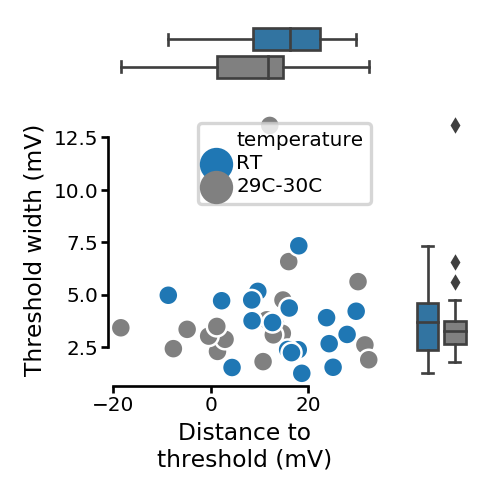

In [23]:
axes = jointplot(
    'thresh_dist',
    'DV',
    'temperature',
    params_cleaned,
    ['RT', '29C-30C'],
    [colors['ser'], 'gray'],
)
axes['scatter_ax'].set_ylabel('Threshold width (mV)')
axes['scatter_ax'].set_xlabel('Distance to\nthreshold (mV)')

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'joint_thresh_params'))

In [24]:
stats.mannwhitneyu(
    params_cleaned.query('temperature == "RT"')['thresh_dist'],
    params_cleaned.query('temperature == "29C-30C"')['thresh_dist'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=209.0, pvalue=0.14123841781192514)

In [25]:
stats.mannwhitneyu(
    params_cleaned.query('temperature == "RT"')['DV'],
    params_cleaned.query('temperature == "29C-30C"')['DV'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=165.0, pvalue=0.9369558676699575)